# Import needed modules and useful functions

In [11]:
#-- necessary modules --#
import numpy as np
np.random.seed(13)
import pandas as pd
import torch
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
import matplotlib as mpl
from scipy import integrate

#-- to computer fes --#
from mlcvs.utils.fes import compute_fes

#-- to run process from jupyter --#
import subprocess
import os
from pathlib import Path
# execute bash command in the given folder
def execute(command, folder, background=False):
    cmd = subprocess.run(command, cwd=folder, shell=True, capture_output = True, text=True, close_fds=background)
    if cmd.returncode == 0:
        print(f'Completed: {command}')
    else:
        print(cmd.stderr)

#-- python script for write correct input files for "ves_md_linearexpansion" plumed module --#
from input_VES import *
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [12]:
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'nstep':200000000, 
    'plumedseed':4525,
    'friction':10,
    'temp':0.5, #kbt units
    #-- upper basin --#
    #'initial_position':[0.6,0.02],
    #-- middle basin --#
    #'initial_position':[-0.05,0.47],
    #-- lower basin --#
    'initial_position':[-0.55,1.45],
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :16,
}
#--------------------------------------#

## M&uuml;ller Potential 
Just have a look at the Muller potential

In [ ]:
#-- MULLER --#
#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

fig,ax = plt.subplots(figsize=(8,8)) 
#-- color map initialization --#
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")
c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
ax.set_xlabel(r"$p.x$ [L]")
ax.set_ylabel(r"$p.y$ [L]")
ax.set_title(r'$U(x,y)$ [$K_b T$]')

#-- highlight the starting point --#
ax.text(0,1.45,r'$Starting$ $Position$',color="red")
draw_circle = plt.Circle((-0.55,1.45), 0.05, color="red")
ax.add_artist(draw_circle)

fig.colorbar(c, ax=ax)
plt.tight_layout()

# Prepare input files for plumed

In [13]:
folder = "unbias/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

# using natural units for Toy Model 
UNITS NATURAL

# compute position for the one particle  
p: POSITION ATOM=1
# adding external potential 
potential: CUSTOM ARG=p.x,p.y FUNC="""+Mullerpot(),""" PERIODIC=NO
ene: BIASVALUE ARG=potential

# Print 
# STRIDE=200 so that the printed time is in 1 ps
PRINT FMT=%g STRIDE=200 FILE=COLVAR ARG=p.x,p.y,ene.bias

ENDPLUMED
""",file=file)

#-- write input files for ves module --#
generate_input_file(name_file=folder+"input",nstep=sim_parameters["nstep"],temp=sim_parameters["temp"],
                    friction=sim_parameters["friction"],random_seed=sim_parameters["plumedseed"],
                    initial_position=sim_parameters["initial_position"])
write_coeff("0",folder+"input")

#-- move necessary files for ves module --#
execute("mv pot_coeffs_input.data unbias",folder=".")
#-- run plumed --#
#execute("plumed ves_md_linearexpansion input",folder=folder)

Completed: mv pot_coeffs_input.data unbias


## Unbias Trajectory 

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

x,y = load_dataframe("unbias/COLVAR").filter(regex="^p.x").values,load_dataframe("unbias/COLVAR").filter(regex="^p.y").values
ax.scatter(x,y,color="black",alpha=1,label="Trajectory",s=10)

#-- prepare grid points
y = np.linspace(-0.3,2.1,150)
x = np.linspace(-1.8,1.2,150)
X, Y = np.meshgrid(x, y)
Z = Mullerfunction(X,Y)
#-- set to 0 the lowest basin --#
Z-=np.min(Z)

#bounds = np.arange(np.min(Z), np.max(Z), 5.)
bounds = np.arange(0, 16, 1.)
cmap = plt.cm.get_cmap('fessa',len(bounds))
colors = list(cmap(np.arange(len(bounds))))
cmap = mpl.colors.ListedColormap(colors[:-1], "")
# set over-color to last color of list 
cmap.set_over("white")

c = plt.pcolormesh(X, Y, Z, cmap=cmap,shading='auto',alpha=1,zorder=-1,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False)
)
c = plt.contourf(X, Y, Z, bounds , cmap=cmap,shading='auto',alpha=1,zorder=-1, linewidth=10,
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="Energu Surface"
)
fig.colorbar(c, ax=ax)
c = plt.contour(X, Y, Z, bounds , cmap="jet",shading='auto',alpha=1, linewidth=5, linestyles="dashed")
#-- if put label on isolines --#
#c.clabel()

ax.legend()
ax.set_xlabel(r"$p.x$ [L]")
ax.set_ylabel(r"$p.y$ [L]")
ax.set_title(r'$U(x,y)$ [$K_b T$]')
plt.tight_layout()

In [ ]:
#-- estimation of Free Energy Surface --#
s = load_dataframe("unbias/COLVAR").filter(regex="^p").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(x) estimate","F(y) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(x,y)$ [L]")
ax.set_ylabel(r"FES [$K_b T$]")

plt.show()

## Unbias simulation DeepTICA Analysis and Export  
  
Before performing the training we have to choose the `lag_time`. How to do that?  

#### How to choose $\tau$ 
The choice of $\tau$ is strictly related to the timescales of the slow modes we are interested in. In addition due to the condition (2), explained in `README.md` file, we do not want overlap between eigenvalues. This mean that choosing either a really small or really large value for $\tau$ it is not a wise choice. Physically speaking choosing a really small value for $\tau$ means that all the slow modes are *slow*, and it becomes difficult to distinguish them. While choosing a very large value for $\tau$ means that all the slow modes are *fast* and their eigenvalues will vanish. In principle every value of $\tau$ in this interval would be good.. but what does it mean *small* and *large*?  
  
One possibility is to look directly at the time auto-correlation function $C(\tau)$ of the descriptors $d_j(\vec x)$, and from it one can estimate their correlation length $\xi$, also called *memory timescale*. When the simulated system is in equilibrium one can expect that the time auto-correlation function decays as an exponential $e^{-\frac{\tau}{\xi}}$. In this case $\xi$ can be estimated by fitting $C(\tau)$. But I will use a more generale definition of $\xi$, which will give us a better estimation: $\xi = \int d \tau C(\tau)$
  
### Time auto-correlation function of the descriptors  

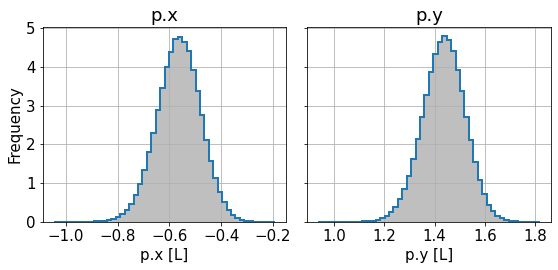

In [14]:
data = load_dataframe("unbias/COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)

for ax,desc in zip(axs.flatten(),descriptors_names):
    data[desc].plot.hist(bins=50,alpha=1,ax=ax,legend=False,grid=True,histtype='step',linewidth=2,density=True)
    data[desc].plot.hist(bins=50,alpha=0.5,ax=ax,legend=False,grid=True,color="grey",density=True)
    ax.set_xlabel(desc + " [L]")
    ax.set_title(desc)

plt.tight_layout()

## Autocorrelation  

$C(k) = \dfrac{\sum_i^{N-k} (Y_i - \bar Y)(Y_{i+k} - \bar Y) }{\sum_i^{N} (Y_i - \bar Y)^2}$  

In [ ]:
#-- Unbias Autocorrelation --#
# this implementation is the same as *autocorr* method in pandas
# but with this I can choose if either normalize the result or not
def my_autocorrelation_pandaslike(x,lag,normed=True):
    
    mean = np.average(x,weights=None)
    variance = np.cov(x,aweights=None)
    N = len(x)
      
    x_lag = x[lag::]
    x_0 = x[:(N-lag)]

    if normed:
        autocorr =  np.sum( np.multiply( (x_0-mean), (x_lag-mean) ) ) / ( (N-lag) * variance ) 
    else:
        autocorr = np.sum( np.multiply( x_0, x_lag )) / (N-lag)
    
    return autocorr

In [ ]:
#-- My Autocorrelation --#
# with this implementation I recall and use the method implemented in *mlcvs* python package
# more details and benchmark in *Time_Lagged_Dataset* folder
def my_autocorrelation(x,lag,weight=None,time=None,normed=True):
   
    N = len(x)
    if weight is None:
        weight = np.ones(N)
    if time is None:
        time = np.arange(0,N)

    data = create_time_lagged_dataset(x, t = time, lag_time = lag, logweights = np.log(weight))
    x_t,x_lag,w_t,w_lag = np.array(data[:][0]),np.array(data[:][1]),np.array(data[:][2]),np.array(data[:][3])
    Nw = np.sum(w_t)
    mean = np.average(x_t,weights=w_t)
    variance = np.cov(x_t,aweights=w_t)

    if normed:
        autocorr = np.sum( np.multiply( np.multiply( (x_t-mean), (x_lag-mean) ), w_lag ) ) / (Nw*variance)
    else:
        autocorr = np.sum( np.multiply( np.multiply( (x_t), (x_lag) ), w_lag ) ) / Nw

    return autocorr

In [ ]:
''' benchmak with pandas implementation 

x = np.transpose(load_dataframe("unbias/COLVAR").filter(regex="^p.x").to_numpy())[0]
autocorr = np.empty(0)
autocorr_pd = np.empty(0)
N = 1000
for k in range(N):
    res = my_autocorrelation_pandaslike(x,lag=k)
    autocorr = np.append(autocorr,res)
    autocorr_pd = np.append(autocorr_pd,data["p.x"].autocorr(k))

plt.plot(np.linspace(0,N,N),autocorr,label="my")
plt.plot(np.linspace(0,N,N),autocorr_pd,label="pandas")
plt.legend()

'''

In [ ]:
data = load_dataframe("unbias/COLVAR")
descriptors_names = data.filter(regex='^p').columns.values

fig,axs = plt.subplots(1,2,figsize=(14,5))#,sharey=True)

last=10
x = np.linspace(0,last+1,last)
acorr = np.empty(last)
timescale = np.empty(len(descriptors_names))
k=0
for desc in descriptors_names:
    print("autocorrelation for ", desc)
    for i in range(last):
        acorr[i] = data[desc].autocorr(i)
    axs[0].plot(x,acorr)
    timescale[k] = integrate.trapz(acorr[:last],x[:last])
    k+=1

times = pd.DataFrame(descriptors_names,columns=["descriptors"])
times["timescale"] = timescale
times.plot(kind="bar",x="descriptors",y="timescale",rot=35,ax=axs[1],fontsize=15,label=r"$\xi$")

axs[0].set_xlabel(r'$\tau$ [time] ')
axs[0].set_title(r'$C(\tau)$')
axs[1].set_title(r'$\xi=\int d\tau C(\tau)$ [time]')

plt.tight_layout()
plt.show()

print(np.max(timescale))
print(np.min(timescale))

#fit_timeacorr(descriptors_names,data,axs=None)

The two $\xi$ are almost the same, as expected from an unbias simulation with no transitions between basins.  
The found value tells us that a good chioce for $\tau$ is around $0.6$, not much smaller and not much bigger.  
I choose $\tau=1$

## Velocity Autocorrelation  
It is possible to obtain an estimate of the diffusion coefficient $D$ from the integral of the velocity time autocorrelation $C_v(\tau)$  
$D = \frac{1}{Dim} \int d \tau C_v(\tau) = \frac{1}{Dim} \int d \tau \langle \vec v(t) \cdot \vec v(t+\tau) \rangle$

In [ ]:
#-- Velocity Autocorrelation --#
def my_autocorrelation_velocity(v,lag):

    N = len(v)
    v_lag = v[lag::]
    v_0 = v[:(N-lag)]

    autocorr = sum ([ np.dot(v_0[i],v_lag[i]) for i in range(N-lag)] ) / (N-lag)
    
    return autocorr

In [ ]:
data = load_dataframe("unbias/COLVAR")
x = data.filter(regex='^p').values

fig,axs = plt.subplots(1,2,figsize=(14,5))

last=10
t = np.linspace(0,last+1,last)
#  time increment in simulation times stride 
dt = 0.005 * 200
acorr = np.empty(last)
velocity = np.array([ (x[i+1]-x[i])/dt for i in range(len(x)-1) ])
#physical dimension
Dim = 2

for i in range(last):
    acorr[i] = my_autocorrelation_velocity(velocity,i)
axs[0].plot(t,acorr,label="avc")
diffcoeff = (1/Dim)*integrate.trapz(acorr[:last],t[:last])

Dcoeff = pd.DataFrame(["D"],columns=["diffusion_coefficient"])
Dcoeff["diffcoeff"] = diffcoeff
Dcoeff.plot(kind="bar",x="diffusion_coefficient",y="diffcoeff",rot=35,ax=axs[1],fontsize=15,label=r"$D$")

axs[0].legend()
axs[0].set_xlabel(r'$\tau$ [time] ')
axs[0].set_title(r'$C_v(\tau)$')
axs[1].set_title(r'$D=\frac{1}{dim} \int d\tau C_v(\tau)$ [$\dfrac{L^2}{time}$]')

plt.tight_layout()
plt.show()

# Training Deep-TICA cvs

In [15]:
#-- TRAINING PARAMETERS --#
n_output = 2
n_input = 2
train_parameters = {
              'descriptors': '^p.',
              'nodes':[n_input,10,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-3,
              'l2_reg':0.,
              'num_epochs':1000,
              'earlystop':True,
              'es_patience':100,
              'es_consecutive':False,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':50,
              #if reweight the timescale
              "reweighting": False,
              }
#--------------------------------------#

## Train Deep-TICA useful functions in utils  
  
```py
def train_deeptica_load(temp=1.0,lag_time=10,path="colvar.data",descriptors="^p.",trainsize=0.8,reweighting=True):
    
    data = load_dataframe(path)
    
    search_values=descriptors
    search_names=descriptors
    X, names, t = data.filter(regex=search_values).values, data.filter(regex=search_names).columns.values, data['time'].values
    n_features = X.shape[1]
    
    if reweighting:
        # Compute logweights for time reweighting
        logweight = data.["opes.bias"].to_numpy()
        #-- the logweights are V(x,y)/T --#
        logweight = logweight/temp
    else:
        print("no weights")
        logweight=None
          
    dataset = create_time_lagged_dataset(X,t=t,lag_time=lag_time,logweights=logweight)
    n_train  = int( trainsize * len(dataset) )
    n_valid  = len(dataset) - n_train
    train_data, valid_data = random_split(dataset,[n_train,n_valid])

    # create dataloaders
    train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
    valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))

    print('Time-lagged pairs:\t',len(dataset))
    print('Training data:\t\t',len(train_data))
    print('Validation data:\t',len(valid_data))

    return data,logweight,train_loader,valid_loader,X

def training(temp,path,train_parameters):

    data,logweight,train_loader,valid_loader,X = train_deeptica_load(temp=temp,lag_time=train_parameters["lag_time"],
                                                                    path=path,descriptors=train_parameters["descriptors"],
                                                                    trainsize=train_parameters['trainsize'],
                                                                    reweighting=train_parameters['reweighting'])
    # DEVICE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # MODEL
    model = DeepTICA_CV(train_parameters['nodes'],activation=train_parameters['activ_type'])
    model.to(device)

    # OPTIMIZER (Adam)
    opt = torch.optim.Adam(model.parameters(), lr=train_parameters['lrate'], weight_decay=train_parameters['l2_reg'])

    # REGULARIZATION
    model.set_optimizer(opt)
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)

    # TRAIN
    model.fit(train_loader,valid_loader,
        standardize_inputs=train_parameters['standardize_inputs'],
        standardize_outputs=train_parameters['standardize_outputs'],
        loss_type=train_parameters['loss_type'],
        n_eig=train_parameters['n_eig'],
        nepochs=train_parameters['num_epochs'],
        info=False, log_every=train_parameters['log_every'])

    return model,data,logweight,X
```

## DeepTICA Analysis and Export

In [16]:
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["temp"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

'''
#-- export checkpoint (for loading the model back to python) and torchscript traced module --#
save_folder = folder+"deeptica/"
try:
    os.mkdir(save_folder)
except:
    print("already exists")
#-- move to cpu before saving results --#
model.to("cpu")
model.export(save_folder)
print("model saved")
'''

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

no weights
Time-lagged pairs:	 999998
Training data:		 699998
Validation data:	 300000
Epoch Train Loss  Valid Loss  Eigenvalues             
50    -0.004      -0.010      0.005  -0.010 
100   -0.007      -0.011      0.006  -0.010 
INFO: Early stopping
114   -0.008      -0.011      0.006  -0.009 
timescales:  [0.19703975        nan]
eigenvalues:  [ 0.00625035 -0.00948455]


## Load existing model  
  
It is possible to load an existing model  

```py
data = load_dataframe(folder+"COLVAR")
search_values="^p."
X, t, logweight = data.filter(regex=search_values).values, data['time'].to_numpy(). data["opes.bias"].to_numpy()

logweight = ( logweight-max(logweight) ) / sim_parameters["temp"]

model = DeepTICA_CV(train_parameters["nodes"],activation=train_parameters['activ_type'])
model.load_checkpoint(folder+"deeptica/model_checkpoint.pt")
```

In [ ]:
#-- plot model loss function --#
def plot_model_lossfunction(model):

    n_eig=len(model.nn[-1].bias)

    fig, axs = plt.subplots(1,2,figsize=(12,5))#,dpi=100)

    loss_train = [x.cpu() for x in model.loss_train]
    loss_valid = [x.cpu() for x in model.loss_valid]

    # Loss function
    ax = axs[0]
    ax.plot(loss_train,'-',label='Train')
    ax.plot(loss_valid,'--',label='Valid')
    ax.set_ylabel('Loss Function')

    # Eigenvalues vs epoch
    ax = axs[1]
    with torch.no_grad():
        evals_train = np.asarray(torch.cat(model.evals_train).cpu())
    for i in range(n_eig):
        ax.plot(evals_train[:,i],label='Eig. '+str(i+1))
    ax.set_ylabel('Eigenvalues')
    
    # Common setup
    for ax in axs:
        if model.earlystopping_.best_epoch is not None:
            if model.earlystopping_.early_stop:
                ax.axvline(model.earlystopping_.best_epoch,ls='dotted',color='grey',alpha=0.5,label='Early Stopping')
                ax.set_xlabel('#Epochs')
                ax.legend(ncol=2)

    plt.tight_layout()

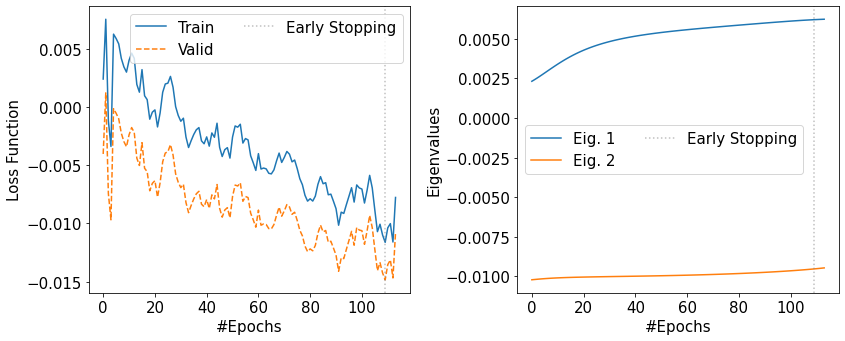

In [17]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [18]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

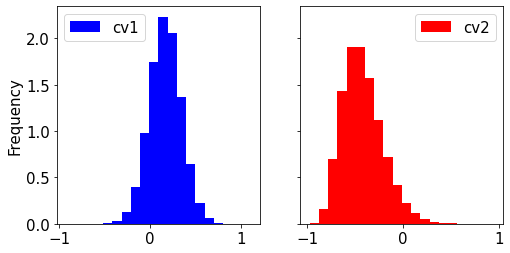

In [19]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex='^p.').columns)
    corr = data[cols].corr(method='pearson')

    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35)
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

### FES estimate from cvs  
Obviously from this first simulation it is not possible to found a cvs that from data are able to distinguish all the possible basins. I recall that our approach is a **data drive approach**.  


In [ ]:
#-- estimation of Free Energy Surface --#
s = data.filter(regex="^cv").to_numpy()
logweight=np.zeros(s.shape[0])

fig, ax = plt.subplots(figsize=(6,6))
for i in range(2):
    fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                        kbt=sim_parameters["temp"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                        plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
ax.grid()
plt.tight_layout()
ax.set_xlabel(r"$(cv1,cv2)$")
ax.set_ylabel("FES [KbT]")

plt.show()

### Isolines  
We are working with a two dimensional Potential, and we are using as descriptors the two cartesian coordinates. This allows us to plot the isolines of the cvs on the physical space $(x,y)$    

In [ ]:
def plot_cvs_isolines(model,limits,points=150,n_out=2,scatter=None,axs=None):

    #-- prepare grid --#
    xx,yy = np.meshgrid(np.linspace(limits[0][0],limits[0][1],points),np.linspace(limits[1][0],limits[1][1],points))
    grid = np.transpose(np.array([xx.reshape(points*points),yy.reshape(points*points)]))

    #-- evaluate cvs on the grid --#
    cvs = []
    for i in range(n_out):
        cvs.append(np.transpose(model(torch.Tensor(grid)).detach().cpu().numpy())[i].reshape(points,points))

    #-- plotting --#
    if axs is None:
        fig,axs = plt.subplots(1,n_out,figsize=(12,6))

    for k,ax in enumerate(axs):
        cset = ax.contourf(xx,yy,cvs[k],linewidths=1,cmap="fessa")
        cset = ax.contour(xx,yy,cvs[k],linewidths=3,cmap="gray",linestyles="dashed")
        ax.clabel(cset,inline=True,fmt='%1.1f',fontsize=15)
        ax.set_xlabel("p.x")
        ax.set_ylabel("p.y")
        ax.set_title('Deep-TICA '+str(k+1))
        if scatter is not None:
            ax.scatter(scatter[:,0],scatter[:,1],s=2,c='white',alpha=0.8)
            ax.set_aspect('equal')
        
    plt.tight_layout()
    plt.show()

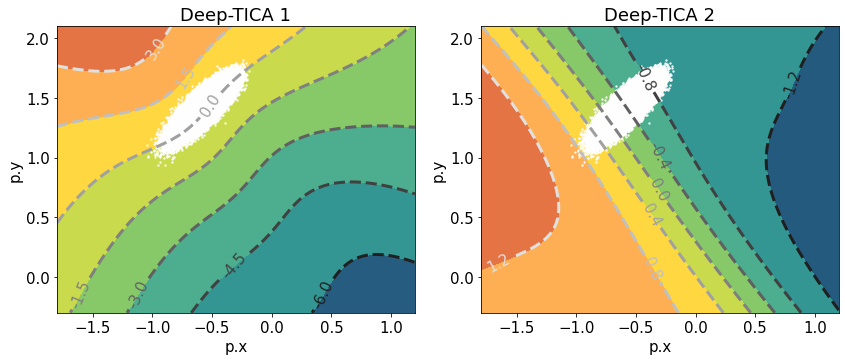

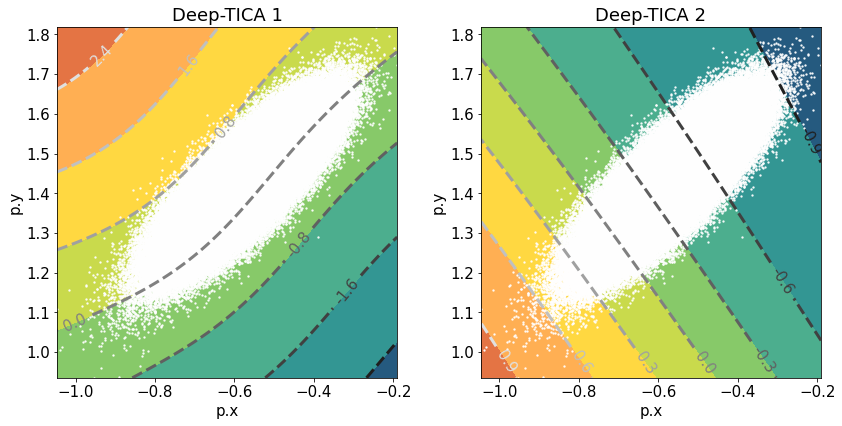

In [20]:
plot_cvs_isolines(model,limits=((-1.8,1.2),(-0.3,2.1)),scatter=X)
lim = ((np.min(X[:,0]),np.max(X[:,0])),(np.min(X[:,1]),np.max(X[:,1])))
plot_cvs_isolines(model,limits=lim,scatter=X)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="p.y",x="p.x",c="cv"+str(k+1),cmap="viridis",ax=ax)
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [ ]:
def Boltzmann_product(model0,model1,X,j=0,k=1,logweight=None,normed=False):

    if logweight is not None:
            weights= np.exp(logweight)
    else:
        weights=np.ones(X.shape[0])

    a = np.transpose(model0(torch.Tensor(X)).detach().cpu().numpy())[j]
    b = np.transpose(model1(torch.Tensor(X)).detach().cpu().numpy())[k]
    sumtot = np.multiply(np.multiply(a,weights),b).mean()

    if normed:
        sumcv1 = np.multiply(np.multiply(a,weights),a).mean()
        sumcv2 = np.multiply(np.multiply(b,weights),b).mean()
        return sumtot/np.sqrt(sumcv1*sumcv2)
    else:
        return sumtot

In [ ]:
Boltzmann_product(model,model,X,j=0,k=1)

This results reflects the fact that we have enforce the symmetrization of $C(\tau)$  
then one can enforce the orthogonality on the data

In [ ]:
def orthogonal_cv(model,X,logweight=None,j=0,k=1):

    a = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[j]
    b = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[k]

    prod_ab = Boltzmann_product(model,model,X,logweight=logweight,j=j,k=k)
    prod_aa = Boltzmann_product(model,model,X,logweight=logweight,j=j,k=j) 

    c = b - prod_ab/(prod_aa) * a

    return c

#-- check scalar product --#
#DeepTICA 1
cv1 = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
#DeepTICA 2 orthogonal to DeepTICA 1
new_cv2 = orthogonal_cv(model,X)
prod = np.multiply(np.multiply(cv1,np.ones(X.shape[0])),new_cv2).mean()
print(prod)

In [ ]:
data["cv2_orthogonal"] = new_cv2
fig,ax = plt.subplots(1,1,figsize=(6,6))
data.plot.scatter(y="p.y",x="p.x",c="cv2_orthogonal",cmap="viridis",ax=ax)
ax.set_title('Deep-TICA 2 orthogonal')